In [ ]:
import pandas as pd
import nltk
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.callbacks import ReduceLROnPlateau

**Mengambil dataset yang telah di upload:**

In [ ]:
df = pd.read_csv('twitter_training.csv')
df = df.drop(columns=['Tweet ID', 'Entity'])

In [ ]:
df

,Sentiment,Tweet Content
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...


**Menghapus dataset yang berisi NaN:**

In [ ]:
# Menampilkan baris yang mengandung nilai NaN
rows_with_nan = df[df.isna().any(axis=1)]

# Menampilkan hasil
print("Baris yang mengandung nilai NaN:")
print(rows_with_nan)

Baris yang mengandung nilai NaN:
      Sentiment Tweet Content
61      Neutral           NaN
553     Neutral           NaN
589     Neutral           NaN
745    Positive           NaN
1105   Positive           NaN
...         ...           ...
73972  Positive           NaN
73973  Positive           NaN
74421  Positive           NaN
74422  Positive           NaN
74423  Positive           NaN

[686 rows x 2 columns]


In [ ]:
# Menghapus baris yang mengandung nilai NaN
df_cleaned = df.dropna()
df = df_cleaned

In [ ]:
# Menampilkan baris yang mengandung nilai NaN
rows_with_nan = df[df.isna().any(axis=1)]

# Menampilkan hasil
print("Baris yang mengandung nilai NaN:")
print(rows_with_nan)

Baris yang mengandung nilai NaN:
Empty DataFrame
Columns: [Sentiment, Tweet Content]
Index: []


**Membagi kelas sentiment menjadi 4 kelas:**

In [ ]:
category = pd.get_dummies(df.Sentiment)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='Sentiment')
df_baru

,Tweet Content,Irrelevant,Negative,Neutral,Positive
0,im getting on borderlands and i will murder yo...,0,0,0,1
1,I am coming to the borders and I will kill you...,0,0,0,1
2,im getting on borderlands and i will kill you ...,0,0,0,1
3,im coming on borderlands and i will murder you...,0,0,0,1
4,im getting on borderlands 2 and i will murder ...,0,0,0,1
...,...,...,...,...,...
74677,Just realized that the Windows partition of my...,0,0,0,1
74678,Just realized that my Mac window partition is ...,0,0,0,1
74679,Just realized the windows partition of my Mac ...,0,0,0,1
74680,Just realized between the windows partition of...,0,0,0,1


**Download keperluan preprocessing:**

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Function untuk preprocessing :**

In [ ]:
def potongAkhirKata(words):
  stemmer = PorterStemmer()
  words = word_tokenize(words)
  filtered_words = ' '.join([stemmer.stem(word) for word in words])
  return filtered_words

def hapusTandaBaca(words):
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  filtered_words = tokenizer.tokenize(words)
  filtered_words = ' '.join(filtered_words)
  return filtered_words

def hapusAngka(words):
  filtered_words = re.sub(r'\d+', '', words)
  return filtered_words

def hapusStopWord(words):
  post_tokenize = word_tokenize(words)
  stop_words = set(stopwords.words('english'))
  filtered_words = [word for word in post_tokenize if word.lower() not in stop_words]
  filtered_words = ' '.join(filtered_words)
  return filtered_words

def hapusSpecialChar(words):
    return re.sub(r'[^a-zA-Z0-9\s]', '', words)

def ubahHurufKecil(words):
    return words.lower()

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(words)
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    return ' '.join(lemmatized_words)

def hapusSingleChar(words):
    cleaned_words = re.sub(r'\s*\b[^IaA]\b\s*', ' ', words)
    return cleaned_words

def preprocess_text(words):
  words = lemmatize_verbs(words)
  words = hapusStopWord(words)
  words = hapusTandaBaca(words)
  words = hapusAngka(words)
  words = hapusSingleChar(words)
  words = ubahHurufKecil(words)
  words = hapusSpecialChar(words)
  return words

**Membagi dataset:**

In [ ]:
tweet_posts = df_baru['Tweet Content'].values
label = df_baru[['Irrelevant', 'Negative', 'Neutral', 'Positive']].values

**Proses Preprocessing & Filter:**

In [ ]:
# Tweet post to string & filter
tweet_posts_str = [str(posts) for posts in tweet_posts]

tweet_posts_filtered = []

for post in tweet_posts_str:
  filtered_sentence = preprocess_text(post)
  tweet_posts_filtered.append(filtered_sentence)

In [ ]:
post_latih, post_test, label_latih, label_test = train_test_split(tweet_posts_filtered, label, test_size=0.2)

In [ ]:
tokenizer = Tokenizer(num_words=23000, oov_token='x')
tokenizer.fit_on_texts(post_latih)

sekuens_latih = tokenizer.texts_to_sequences(post_latih)
sekuens_test = tokenizer.texts_to_sequences(post_test)

padded_latih = pad_sequences(sekuens_latih, padding='post', maxlen=20, truncating='post')
padded_test = pad_sequences(sekuens_test, padding='post', maxlen=20, truncating='post')

**Membuat Model:**

In [103]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=23000, output_dim=17),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.006), metrics=['accuracy'])

**Latih Model:**

In [104]:
# function callback autostop
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.85):
      print("\nAkurasi telah mencapai > 85%!")
      self.model.stop_training = True
callbacks = myCallback()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=6, min_lr=1e-6)

num_epochs = 100

history = model.fit(padded_latih,
                    label_latih,
                    epochs=num_epochs,
                    batch_size=300,
                    validation_data=(padded_test, label_test),
                    callbacks=(reduce_lr, callbacks),
                    verbose=2)

Epoch 1/100
198/198 - 23s - loss: 1.1846 - accuracy: 0.4452 - val_loss: 0.9449 - val_accuracy: 0.6139 - lr: 0.0060 - 23s/epoch - 117ms/step
Epoch 2/100
198/198 - 7s - loss: 0.7982 - accuracy: 0.6903 - val_loss: 0.6892 - val_accuracy: 0.7517 - lr: 0.0060 - 7s/epoch - 35ms/step
Epoch 3/100
198/198 - 4s - loss: 0.5423 - accuracy: 0.8082 - val_loss: 0.5491 - val_accuracy: 0.8080 - lr: 0.0060 - 4s/epoch - 20ms/step
Epoch 4/100
198/198 - 3s - loss: 0.4225 - accuracy: 0.8494 - val_loss: 0.5204 - val_accuracy: 0.8211 - lr: 0.0060 - 3s/epoch - 15ms/step
Epoch 5/100
198/198 - 2s - loss: 0.3583 - accuracy: 0.8703 - val_loss: 0.4703 - val_accuracy: 0.8322 - lr: 0.0060 - 2s/epoch - 11ms/step
Epoch 6/100
198/198 - 3s - loss: 0.3070 - accuracy: 0.8877 - val_loss: 0.5059 - val_accuracy: 0.8382 - lr: 0.0060 - 3s/epoch - 14ms/step
Epoch 7/100
198/198 - 2s - loss: 0.2859 - accuracy: 0.8969 - val_loss: 0.4896 - val_accuracy: 0.8478 - lr: 0.0060 - 2s/epoch - 12ms/step
Epoch 8/100
198/198 - 2s - loss: 0.269

**Membuat Gafik Plot:**

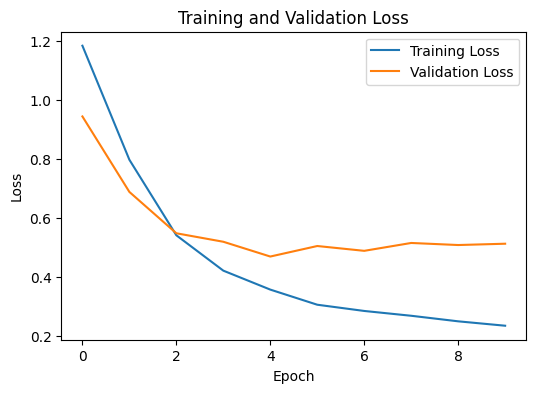

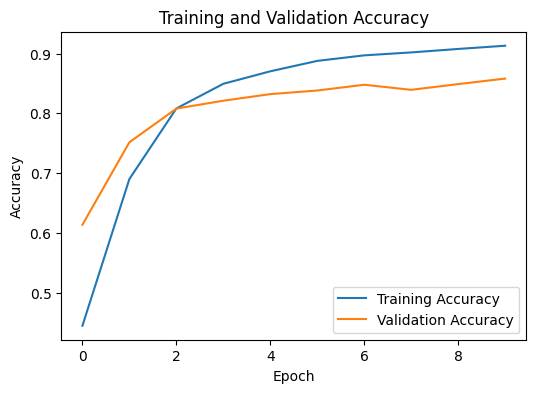

In [105]:
# mendapatkan nilai loss dan akurasi dari history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# grafik loss
plt.figure(figsize=(6, 4))
plt.subplot(1, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# grafik akurasi
plt.figure(figsize=(6, 4))
plt.subplot(1, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Menampilkan grafik
plt.show()